# import

In [1]:
import sys,gc,os,glob,cv2,csv
import pandas as pd
import pickle,subprocess,json,copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output
from IPython.display import HTML

import numpy as np
import scipy
import scipy.interpolate as interpolate
from scipy.ndimage import median_filter
from scipy.ndimage.filters import gaussian_filter1d
import scipy.optimize

from numba.decorators import jit,autojit

In [2]:
from mycolor import set_col_extra
from util_ana import stdsig,ps_number_detect,affine_transform,ps_trj
from util_ana import label_ps,labeling,labeling_im

In [3]:
sys.path.append('./opmap/')
from opmap.videoData import VideoData
from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseMapHilbert import PhaseMapHilbert
from opmap.phaseVarianceMap import PhaseVarianceMap
from opmap.PhaseVariancePeakMap import PhaseVariancePeakMap
from opmap.util import makeMovie

## functions

In [4]:
def saveMovie(mov_type, dir_path):
    if mov_type == 'optical': m_rate = 80
    if mov_type == 'extra': m_rate = 20
    cmd = 'ffmpeg -r {0} -y -i "{1}/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{1}.mp4"'.format(m_rate, dir_path.rstrip('/'))
    os.system(cmd)

def blend_mask(target_path, mask_path, back_path=None):

    files = sorted(glob.glob(os.path.join(target_path,"00*.png")))
    img_mask = cv2.imread(mask_path)
    
    if back_path is not None: 
        save_path = target_path.rstrip('/')+'_over'
        if not os.path.exists(save_path): os.makedirs(save_path)
            
        img_back = cv2.imread(back_path)
        for i,path in enumerate(files):
            img = cv2.imread(path)
            img_fore = img_back.copy()
            img_fore[(img_mask == [255,255,255])] = img[(img_mask == [255,255,255])]
            img_masked = cv2.addWeighted(img_fore, 0.7, img_back, 0.3, 0)
            cv2.imwrite(os.path.join(save_path,"{0:0>6}.png".format(i)),img_masked)
    else:
        save_path = target_path.rstrip('/')+'_mask'
        if not os.path.exists(save_path): os.makedirs(save_path)
        
        for i,path in enumerate(files):
            img = cv2.imread(path)
            img_fore = img_mask.copy()
            img_fore[(img_mask == [255,255,255])] = img[(img_mask == [255,255,255])]
            img_masked = cv2.addWeighted(img_fore, 0.7, img, 0.3, 0)
            cv2.imwrite(os.path.join(save_path,"{0:0>6}.png".format(i)),img_masked)
        
    return save_path

@autojit
def applyBandpass(X, f_sample, cut_low, cut_high):
    
    D = np.zeros_like(X)
    _, H, W = X.shape
    nyq = f_sample/2.0
    fe =  np.array([cut_low,cut_high])/ nyq
    b = scipy.signal.firwin(128, fe, pass_zero=False)
        
    for i in range(H):
        for j in range(W):
            ts = scipy.signal.filtfilt(b, 1, X[:,i,j], padlen=len(b))
            #ts = 2.0*( ts - ts.min() ) / ( ts.max() - ts.min() )-1.0
            D[:,i,j] = ts
    
    return D

def sw_trajectory(pv, pv_size = 9):
    thre = 1 - math.sqrt( -math.log(0.05) / ( pv_size**2) )
    traj = np.sum((pv>thre)*1, axis=0)
    return traj

def sw_trajectory(pv, pv_size = 9):
    thre = 1 - math.sqrt( -math.log(0.05) / ( pv_size**2) )
    traj = ((pv>thre)*1).astype(np.float64)
    return traj

def normalize(im):
    return (im - im.min())/max(im.max()-im.min(), 1.0e-10)

def ncc(a, b):
    a_ = normalize(a)
    b_ = normalize(b)
    ncc = np.sum(a_ * b_)
    ncc /= np.sqrt( np.sum(a_**2)*np.sum(b_**2) )
    return ncc
    

def zncc(a, b):
    a_ = normalize(a)
    b_ = normalize(b)
    a_ -= np.mean(a_)
    b_ -= np.mean(b_)
    zncc = np.sum(a_ * b_)
    zncc /= np.sqrt( np.sum(a_**2)*np.sum(b_**2) )
    return zncc

def CenterOfGravity(mat):
    hei,wid = mat.shape
    Tile=np.arange(wid,dtype=float)-(wid-1.0)/2.0
    Tx = np.tile(Tile,[hei,1]) # Ty = Tx.T
    Sum = np.sum(mat)
    Ax = np.sum(mat*Tx)/Sum
    Ay = np.sum(mat*Tx.T)/Sum
    #return [Ay,Ax]
    return math.atan2(Ay, Ax), np.linalg.norm(np.array([Ay, Ax]))

def rate_non_passive(traj):
    flag_np = (np.sum(np.sum(traj, axis=1), axis=1)>0)*1
    rate_np = np.sum(flag_np)/float(len(flag_np))
    return rate_np

def apply_mask(data, mask): 
    mask_v = np.zeros_like(data)
    mask_v[:,:,:] = mask[None,:,:]
    return data*mask_v

/usr/local/lib/python3.5/dist-packages/numba/decorators.py:33: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


## Parameters

In [14]:
ipath = '/mnt/Jalife/ExperimentData/'
opath = "./"
out_date = "20191231"
extra_dir = "/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/ExTRa_result/"
load_dir = "/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/"
f_start = 0
f_end = 500

### ROI, 電極位置

In [7]:
pos_unip = np.load("pos_unip_ex.npy")      # ExTRa座標上のUnipolar電極位置
elec_list = np.load("list_pos_unip_op.npy")# Optical座標上のUnipolar電極位置リスト

In [8]:
roi_extra = np.load("./roi_extra.npy")
mask_extra_nan = np.copy(roi_extra)
mask_extra_nan[mask_extra_nan==0] = np.nan

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


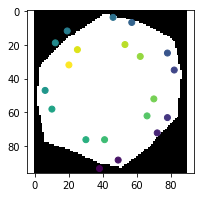

In [9]:
fig=plt.figure(figsize=(3,3))
plt.axis('equal')
ax = plt.subplot()
ax.imshow(roi_extra, cmap='gray')
ax.scatter(pos_unip[:,0], pos_unip[:,1], c=np.arange(len(pos_unip)))


## 解析パラメータ

In [10]:
ana_params = {
    "optical":{
        "cam":{
            "Type":"sa4",
        },
        "vmem":{
            "Diff_min":30,
            "Closing":5,
            "Erosion":5,
            "Smooth":9,
            "Lowcut":2.0,
            "Highcut":50.0
        }, 
        "pmap":{
            "Smooth":1,
            "Shrink":2,
            "Sigma_xy":1,
            "Offset":np.pi,
        },
        "pvmap":{
            "Size":5,
            "Threshold":0.65
        },
    },"extra":{
       "extra_pmap":{
        },
        "extra_pvmap":{
            "Size":5,
            "Threshold":0.65
        },
    }
}
cam_params = ana_params["optical"]["cam"]
vmem_params = ana_params["optical"]["vmem"]
pmap_params = ana_params["optical"]["pmap"]
pvmap_params = ana_params["optical"]["pvmap"]
epmap_params = ana_params["extra"]["extra_pmap"]
epvmap_params = ana_params["extra"]["extra_pvmap"]

## Main

In [11]:
sess_list = pd.read_csv("./session_all.csv")
sess_list

,id,sample,session,elec_pattern,extra_dir,extra_sess,extra_delay
0,5,20180425-1,5,0,20180425,e002_04251532,0
1,9,20180425-1,9,0,20180425,e006_04251612,0
2,21,20180426-1,6,1,20180426,e001_04261048,0
3,25,20180426-1,10,3,20180426,e004_04261058,136
4,28,20180426-1,13,4,20180426,e007_04261105,0
5,50,20180612-1,6,6,20180612,e001_06121525,136
6,52,20180612-1,8,7,20180612,e003_06121541,0
7,54,20180612-1,10,8,20180612,e005_06121551,136
8,57,20180612-1,13,9,20180612,e008_06121610,0
9,64,20180614-1,5,10,20180614,e001_06141447,0


In [16]:
for i, row in (sess_list.iterrows()):
    
    if not i in [3]: continue
    session = "{0}/C001H001S{1:0>4}".format(row["sample"],row["session"])
    src_path = os.path.join(ipath, session)
    print(i, src_path)
    
    load_path = os.path.join(load_dir, session)
    print(load_path)
    
    ###################################################################################################
    print ('pmap_ex...', end="")
    npy_path = os.path.join(load_path,"pmap_ex.npy")
    pmap_ex = PhaseMap.load(npy_path)
    pmap_ex.roi = roi_extra
    pv_ex = PhaseVarianceMap()
    print ("loaded")
        
    print ('pmap_op_on_ex...',end="")
    npy_path = os.path.join(load_path,"pmap_op_on_ex.npy")
    pmap_op_on_ex = PhaseMap.load(npy_path)
    pmap_op_on_ex.roi = roi_extra
    print ("loaded")


3 /mnt/Jalife/ExperimentData/20180426-1/C001H001S0010
/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180426-1/C001H001S0010
pmap_ex...loaded
pmap_op_on_ex...loaded


In [17]:
pmap_ex.data.shape

(398, 96, 90)

In [18]:
pmap_op_on_ex.data.shape

(534, 96, 90)

In [82]:
pmap_ex.roi = roi_extra

In [83]:
pv_ex = PhaseVarianceMap(pmap_ex, size=3)

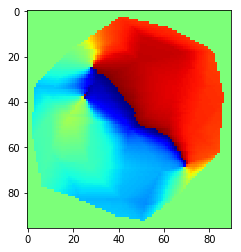

In [84]:
pmap_ex.showFrame(100)

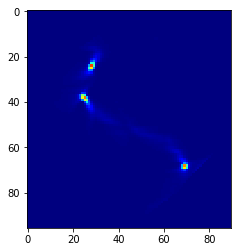

In [85]:
#pv_ex.morphROI(erosion=3)
pv_ex.showFrame(100)

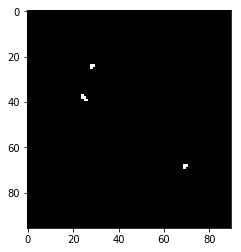

In [88]:
pvp_ex = PhaseVariancePeakMap(pv_ex)
pvp_ex.showFrame(100)

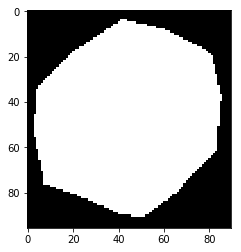

In [86]:
pv_ex.showROI()

In [52]:
im = pmap_ex.data[100]
size = 3

kernel = np.ones((size, size), dtype=np.float32)
kernel /= np.sum(kernel)
im_cos = np.cos(im)
im_sin = np.sin(im)
im_cos = scipy.signal.convolve2d(im_cos, kernel, mode = 'same', boundary = 'fill')
im_sin = scipy.signal.convolve2d(im_sin, kernel, mode = 'same', boundary = 'fill')

im_pv = 1.0 - np.abs( im_cos + 1j * im_sin )

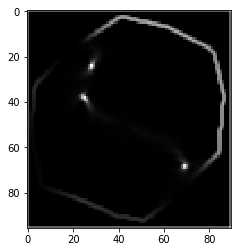

In [54]:
plt.imshow(im, cmap='hsv')
plt.imshow(im_pv, cmap='gray')

In [15]:
for i, row in (sess_list.iterrows()):
    
    if row["extra_delay"] == 0: continue

    session = "{0}/C001H001S{1:0>4}".format(row["sample"],row["session"])
    src_path = os.path.join(ipath, session)
    print(i, src_path)
    
    save_path = os.path.join(os.path.join(opath,out_date), session)
    if not os.path.exists(save_path): os.makedirs(save_path)
    with open(os.path.join(save_path, 'params.json'), 'w') as f:
        json.dump(ana_params, f, indent=4)
       
    # image size check
    fsrc_path = os.path.join(src_path,"C001H001S{0:0>4}".format(row["session"])+"000001.raww")
    if(os.path.getsize(fsrc_path) < 150000):
        img_size = 256
    elif(os.path.getsize(fsrc_path) > 600000):
        img_size = 1024
    else:
        img_size = 512
        
    # affine transform matrix
    shrink = pmap_params["Shrink"]
    pos = elec_list[row["elec_pattern"],:,:] # 20 x 3
    
    affine_v = cv2.getPerspectiveTransform(
        pos_unip[(0,4,8,10),:2].astype(np.float32), 
        pos[(0,4,8,10),:2].astype(np.float32))
    affine_p = cv2.getPerspectiveTransform(
        pos_unip[(0,4,8,10),:2].astype(np.float32), 
        pos[(0,4,8,10),:2].astype(np.float32)//shrink)
    affine_v_inv = cv2.getPerspectiveTransform(
        pos[(0,4,8,10),:2].astype(np.float32),
        pos_unip[(0,4,8,10),:2].astype(np.float32))
    affine_p_inv = cv2.getPerspectiveTransform(
        pos[(0,4,8,10),:2].astype(np.float32)//shrink,
        pos_unip[(0,4,8,10),:2].astype(np.float32))
    np.save(os.path.join(save_path,"affine_v"),  affine_v)
    np.save(os.path.join(save_path,"affine_p"),  affine_p)
    np.save(os.path.join(save_path,"affine_v_inv"),  affine_v_inv)
    np.save(os.path.join(save_path,"affine_p_inv"),  affine_p_inv)
        
    # mask images
    roi_optical_v = cv2.warpPerspective( roi_extra, affine_v, (img_size, img_size))
    roi_optical_p = cv2.warpPerspective( roi_extra, affine_p, (img_size//shrink, img_size//shrink))
    mask_optical_v_nan = np.copy(roi_optical_v) 
    mask_optical_p_nan = np.copy(roi_optical_p)
    mask_optical_v_nan[(mask_optical_v_nan == 1)] = np.nan
    mask_optical_p_nan[(mask_optical_p_nan == 1)] = np.nan
    path_mask_optical_v_nan = os.path.join(save_path,"mask_optical_v_nan.png")
    path_mask_optical_p_nan = os.path.join(save_path,"mask_optical_p_nan.png")
    plt.imsave(
        path_mask_optical_v_nan, 
        mask_optical_v_nan, cmap = "gray", vmax= 1,vmin=0)
    plt.imsave(
        path_mask_optical_p_nan, 
        mask_optical_p_nan, cmap = "gray", vmax= 1,vmin=0)
    
    ###################################################################################################
    print ('vmem...', end="")
    if False:
        cam = RawCam(
            src_path,
            cam_type=cam_params["Type"],
            image_height=img_size, image_width=img_size,
            frame_start=f_start*4,
            frame_end=f_end*4)
            #frame_end = 1)
        if True:
            vmem = VmemMap(cam)
            vmem.setDiffRange(diff_min = vmem_params["Diff_min"])
            vmem.morphROI(closing = vmem_params["Closing"])
            vmem.morphROI(erosion = vmem_params["Erosion"])
            vmem.smooth(vmem_params["Smooth"])
            vmem.smooth(vmem_params["Smooth"])
            vmem.data = applyBandpass(
                vmem.data, f_sample=1000, 
                cut_low =vmem_params["Lowcut"], cut_high = vmem_params["Highcut"])    
            vmem.data *= vmem.roi
        print ('done...', end="")
        plt.imsave(os.path.join(save_path, "cam_v.png"), cam.data[0,:], cmap='gray')
        plt.imsave(os.path.join(save_path, "cam_p.png"), cam.data[0,::shrink,::shrink], cmap='gray')
        plt.figure(figsize=(14,7))
        ax = plt.subplot(121)
        ax.imshow(cam.data[0,:], cmap='gray')
        ax.scatter(pos[:,0], pos[:,1], c=np.arange(len(pos)))
        ax = plt.subplot(122)
        im = cv2.warpPerspective(cam.data[0,:], affine_v_inv, (90,96))
        im *= roi_extra
        ax.imshow(im, cmap='gray')
        ax.scatter(pos_unip[:,0], pos_unip[:,1], c=np.arange(len(pos)))
        plt.savefig(os.path.join(save_path,"electrodes.png"))
        if True:
            save_dir = os.path.join(save_path,"vmem")
            np.save(save_dir, vmem.data)
            vmem.saveImage(save_dir)
            saveMovie('optical', save_dir)
            save_dir = blend_mask(save_dir, path_mask_optical_v_nan, os.path.join(save_path, "cam_v.png"))
            print(save_dir)
            saveMovie('optical', save_dir)
        print('saved')
    elif False:
        npy_path = os.path.join(save_path,"vmem.npy")
        vmem = VmemMap.load(npy_path)
        print('loaded')
    else:
        print('skipped')
        
    ###################################################################################################
    print ('pmap_op...', end="")
    if False:
        pmap_op = PhaseMapHilbert(
            vmem, width = img_size//pmap_params["Shrink"], 
            sigma_t = 0, sigma_xy = pmap_params["Sigma_xy"])
        pmap_op.data += pmap_params["Offset"]
        pmap_op.data[(pmap_op.data> np.pi)] -= 2*np.pi
        pmap_op.data[(pmap_op.data<-np.pi)] += 2*np.pi
        pmap_op.data *= pmap_op.roi
        pmap_op.data *= -1 # extraの位相変化の方向と合わせる
        print('done...', end="")
        save_dir = os.path.join(save_path,"pmap_op")
        np.save(save_dir, pmap_op.data)
        pmap_op.cmap = set_col_extra()
        pmap_op.saveImage(save_dir)
        saveMovie('optical', save_dir)
        save_dir_over = blend_mask(save_dir, path_mask_optical_p_nan)
        saveMovie('optical', save_dir_over)
        save_dir_mask = blend_mask(save_dir, path_mask_optical_p_nan, os.path.join(save_path, "cam_p.png"))
        saveMovie('optical', save_dir_mask)
        print('saved')
    elif True:
        npy_path = os.path.join(save_path,"pmap_op.npy")
        pmap_op = PhaseMap.load(npy_path)
        print('loaded')        
    else:
        print('skipped')
        
        
    ###################################################################################################
    print ('pmap_ex...', end="")
    if True:
        npy_path = os.path.join(os.path.join( extra_dir, str(row["extra_dir"])), row["extra_sess"])+'.npy'
        pmap_ex = PhaseMap.load(npy_path)
        pmap_ex.cmap = set_col_extra()
        pmap_ex.data = pmap_ex.data[row["extra_delay"]:,::-1,:]
        print ('done...',end="")
        save_dir = os.path.join(save_path,"pmap_ex")
        np.save(save_dir, pmap_ex.data)
        pmap_ex.saveImage(save_dir)
        saveMovie('extra', save_dir)
        pmap_ex_mask = copy.deepcopy(pmap_ex)
        pmap_ex_mask.data = apply_mask(pmap_ex.data, mask_extra_nan)
        save_dir = os.path.join(save_path,"pmap_ex_mask")
        pmap_ex_mask.saveImage(save_dir)
        saveMovie('extra', save_dir)
        del(pmap_ex_mask)
        print('saved')
    elif True:
        npy_path = os.path.join(save_path,"pmap_ex.npy")
        pmap_ex = PhaseMap.load(npy_path)
        print('loaded')
    else:
        print('skipped')
        
    ###################################################################################################
    print ('pmap_op_on_ex...',end="")
    if False:
        pmap_op_on_ex = copy.deepcopy(pmap_ex)
        L,H,W = pmap_ex.data.shape
        for i in range(L):
            if (f_start+i)*4 >= len(pmap_op.data): break
            pmap_op_on_ex.data[i,:,:] = cv2.warpPerspective(
                pmap_op.data[(f_start+i)*4,:,:], 
                affine_p_inv, (W,H),
                flags = cv2.INTER_NEAREST)
        print ("done...",end="")
        save_dir = os.path.join(save_path,"pmap_op_on_ex")
        np.save(save_dir, pmap_op_on_ex.data)
        pmap_op_on_ex.cmap = set_col_extra()
        pmap_op_on_ex.saveImage(save_dir)
        saveMovie('extra', save_dir)
        pmap_op_on_ex_mask = copy.deepcopy(pmap_op_on_ex)
        pmap_op_on_ex_mask.data = apply_mask(pmap_op_on_ex.data, mask_extra_nan)
        save_dir = os.path.join(save_path,"pmap_op_on_ex_mask")
        pmap_op_on_ex_mask.saveImage(save_dir)
        saveMovie('extra', save_dir)
        del(pmap_op_on_ex_mask)
        print('saved')
    elif True:
        npy_path = os.path.join(save_path,"pmap_op_on_ex.npy")
        pmap_op_on_ex = PhaseMap.load(npy_path)
        print ("loaded")
    else:
        print ("skipped")

    ###################################################################################################
    print ('pmap_ex_on_op...',end="")
    if True:
        pmap_ex_on_op = copy.deepcopy(pmap_op)
        L,H,W = pmap_op.data.shape
        for i in range(L):
            if (i-f_start)//4 >= len(pmap_ex.data): break
            pmap_ex_on_op.data[i,:,:] = cv2.warpPerspective(
                pmap_ex.data[(i-f_start)//4,:,:], 
                affine_p, (W,H),
                flags = cv2.INTER_NEAREST)
        print ("done...",end="")
        save_dir = os.path.join(save_path,"pmap_ex_on_op")
        np.save(save_dir, pmap_ex_on_op.data)
        pmap_ex_on_op.cmap = set_col_extra()
        pmap_ex_on_op.saveImage(save_dir)
        saveMovie('optical', save_dir)
        save_dir_over = blend_mask(save_dir, path_mask_optical_p_nan)
        saveMovie('optical', save_dir_over)
        save_dir_mask = blend_mask(save_dir, path_mask_optical_p_nan, os.path.join(save_path, "cam_p.png"))
        saveMovie('optical', save_dir_mask)
        print ("saved")        
    elif False:
        npy_path = os.path.join(save_path,"pmap_op_on_ex.npy")
        pmap_ex_on_op = PhaseMap.load(npy_path)
        print ("loaded")
    else:
        print ("skipped")
        

    #del(vmem)
    del(pmap_op)
    del(pmap_op_on_ex)
    del(pmap_ex)
    del(pmap_ex_on_op)

3 /mnt/Jalife/ExperimentData/20180426-1/C001H001S0010
vmem...skipped
pmap_op...loaded
pmap_ex...done...saved
pmap_op_on_ex...loaded
pmap_ex_on_op...done...saved
5 /mnt/Jalife/ExperimentData/20180612-1/C001H001S0006
vmem...skipped
pmap_op...loaded
pmap_ex...done...saved
pmap_op_on_ex...loaded
pmap_ex_on_op...done...saved
7 /mnt/Jalife/ExperimentData/20180612-1/C001H001S0010
vmem...skipped
pmap_op...loaded
pmap_ex...done...saved
pmap_op_on_ex...loaded
pmap_ex_on_op...done...saved
10 /mnt/Jalife/ExperimentData/20180614-1/C001H001S0007
vmem...skipped
pmap_op...loaded
pmap_ex...done...saved
pmap_op_on_ex...loaded
pmap_ex_on_op...done...saved
14 /mnt/Jalife/ExperimentData/20180731-1/C001H001S0005
vmem...skipped
pmap_op...loaded
pmap_ex...done...saved
pmap_op_on_ex...loaded
pmap_ex_on_op...done...saved
18 /mnt/Jalife/ExperimentData/20180731-1/C001H001S0020
vmem...skipped
pmap_op...loaded
pmap_ex...done...saved
pmap_op_on_ex...loaded
pmap_ex_on_op...done...saved
19 /mnt/Jalife/ExperimentData/2

    
    traj_ex = sw_trajectory(pv_ex[start//4:end//4,:,:])
    cpv_ex = np.sum(traj_ex, axis=0)
    cpv_ex_ = np.zeros_like(cpv_ex)
    cpv_ex_[~np.isnan(cpv_ex)] = cpv_ex[~np.isnan(cpv_ex)]
        
    mask = np.load(os.path.join(save_path, 'mask_proi.npy'))
    
    mask_t = cv2.warpAffine(
        mask, affine_t_inv[:2], cpv_ex.shape, 
        flags = cv2.INTER_NEAREST)
    
    cpv_ex_ *= mask_t
    
    pv_op = np.load( os.path.join(save_path, 'pvmap.npy'))
    L,H,W = traj_ex.shape
    traj_op = np.zeros((len(pv_op), H, W))
    for i, im in enumerate(pv_op[start:end,:,:]):
        im_t = cv2.warpAffine(
            im, affine_t_inv[:2], cpv_ex.shape,
            flags = cv2.INTER_NEAREST)
        traj_op[i] = sw_trajectory(im_t[np.newaxis, :,:])[0]
    
    cpv_op_ = np.sum(traj_op, axis=0)
    cpv_op_t = np.zeros_like(cpv_op_)
    cpv_op_t[~np.isnan(cpv_op_)] = cpv_op_[~np.isnan(cpv_op_)]
    cpv_op_t *= mask_t
    
    pos_op.append(CenterOfGravity(cpv_op_t))
    pos_ex.append(CenterOfGravity(cpv_ex_))
    
    rate_op.append(rate_non_passive(traj_op))
    rate_ex.append(rate_non_passive(traj_ex))
    
    L,H,W = vmem.data.shape
    plt.plot(vmem.data[:,H//2,W//2])

    L,H,W = pmap.data.shape
    plt.plot(pmap.data[:,H//2,W//2])
    plt.show()

    save_dir = os.path.join(save_path,"vmem")
    vmem.saveImage( save_dir)
    saveMovie('optical', save_dir)
    save_dir = applyMask(os.path.join(save_path,"vmem"), path_mask_vroi)
    saveMovie('optical', save_dir)

    save_dir = os.path.join(save_path, "cam")
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    plt.imsave( os.path.join(save_dir, 'cam.png'),  cam.data[0,:,:],cmap = "gray")

    save_dir = os.path.join(save_path,"pvmap")
    pvmap.saveImage(save_dir)
    saveMovie('optical', save_dir)
    save_dir = applyMask(save_dir, path_mask_proi)
    saveMovie('optical', save_dir)

    save_dir = os.path.join(save_path,"psmap")
    psmap.saveImage(save_dir)
    saveMovie('optical', save_dir)
    save_dir = applyMask(save_dir, path_mask_proi)
    saveMovie('optical', save_dir)

    pmap.saveImage(save_dir)
    saveMovie('extra', save_dir)

    save_dir = os.path.join(save_path,"pvmap_ex")
    pvmap.saveImage(save_dir)
    saveMovie('extra', save_dir)

    save_dir = os.path.join(save_path,"psmap_ex")
    psmap.saveImage(save_dir)
    saveMovie('extra', save_dir)


    fig = plt.figure()
    plt.title(session)
    plt.subplot(121)
    plt.imshow(cpv_op_t, cmap='jet')
    plt.title('opt')
    plt.subplot(122)
    plt.imshow(cpv_ex_, cmap='jet')
    plt.title('ext')
    plt.savefig(os.path.join(save_path, "traj_compare.png"))
    plt.show()    